In [29]:
import os


In [30]:
import glob
import os

import cv2
import numpy as np


def create_mp4_animation(input_folder, output_file="animation.mp4", fps=24, max_duration=10):
    """
    Tworzy animację MP4 z obrazów w podanym katalogu, ograniczając czas trwania.
    
    Parametry:
    input_folder (str): Ścieżka do katalogu z obrazami
    output_file (str): Nazwa pliku wyjściowego
    fps (int): Liczba klatek na sekundę
    max_duration (float): Maksymalny czas trwania animacji w sekundach
    """
    # Pobierz listę wszystkich obrazów z katalogu (png, jpg, jpeg)
    image_files = sorted(glob.glob(os.path.join(input_folder, "*.[pP][nN][gG]")) +
                        glob.glob(os.path.join(input_folder, "*.[jJ][pP][gG]")) +
                        glob.glob(os.path.join(input_folder, "*.[jJ][pP][eE][gG]")))
    
    if not image_files:
        print("Brak obrazów w podanym katalogu!")
        return
    
    # Oblicz maksymalną liczbę klatek na podstawie czasu trwania
    max_frames = int(fps * max_duration)
    # Ogranicz listę obrazów do maksymalnej liczby klatek
    image_files = image_files[:max_frames]
    
    if not image_files:
        print("Brak obrazów po ograniczeniu liczby klatek!")
        return
    
    # Wczytaj pierwszy obraz, aby określić rozmiar
    img = cv2.imread(image_files[0])
    if img is None:
        print(f"Nie można wczytać obrazu {image_files[0]}!")
        return
    height, width, _ = img.shape
    
    # Zainicjuj writer dla MP4
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Kodek MP4
    out = cv2.VideoWriter(output_file, fourcc, fps, (width, height))
    
    # Przetwarzaj obrazy
    for file in image_files:
        try:
            img = cv2.imread(file)
            if img is None:
                print(f"Nie można wczytać obrazu {file}")
                continue
            
            # Sprawdź, czy rozmiar obrazu jest zgodny
            if img.shape[:2] != (height, width):
                img = cv2.resize(img, (width, height))
            
            out.write(img)
        except Exception as e:
            print(f"Błąd przy przetwarzaniu {file}: {e}")
    
    # Zwolnij zasoby
    out.release()
    print(f"Animacja zapisana jako {output_file}")

# Przykład użycia
if __name__ == "__main__":
    # Podaj ścieżkę do katalogu z obrazami
    input_folder = "data/159/"
    create_mp4_animation(input_folder, "wynikowa_animacja.mp4", fps=24, max_duration=10)


Animacja zapisana jako wynikowa_animacja.mp4


Train dataset size: 594
Validation dataset size: 198
Test dataset size: 198
Epoch 1/20, Train Loss: 0.702861, Val Loss: 0.213222
Best model saved with Val Loss: 0.213222
Epoch 2/20, Train Loss: 0.339642, Val Loss: 0.199189
Best model saved with Val Loss: 0.199189
Epoch 3/20, Train Loss: 0.267012, Val Loss: 0.129018
Best model saved with Val Loss: 0.129018
Epoch 4/20, Train Loss: 0.229487, Val Loss: 0.119620
Best model saved with Val Loss: 0.119620
Epoch 5/20, Train Loss: 0.222108, Val Loss: 0.114358
Best model saved with Val Loss: 0.114358
Epoch 6/20, Train Loss: 0.204386, Val Loss: 0.112740
Best model saved with Val Loss: 0.112740
Epoch 7/20, Train Loss: 0.192783, Val Loss: 0.100209
Best model saved with Val Loss: 0.100209
Epoch 8/20, Train Loss: 0.197951, Val Loss: 0.138281
Epoch 9/20, Train Loss: 0.184678, Val Loss: 0.110465
Epoch 10/20, Train Loss: 0.184376, Val Loss: 0.098122
Best model saved with Val Loss: 0.098122
Epoch 11/20, Train Loss: 0.167813, Val Loss: 0.136246
Epoch 12/20

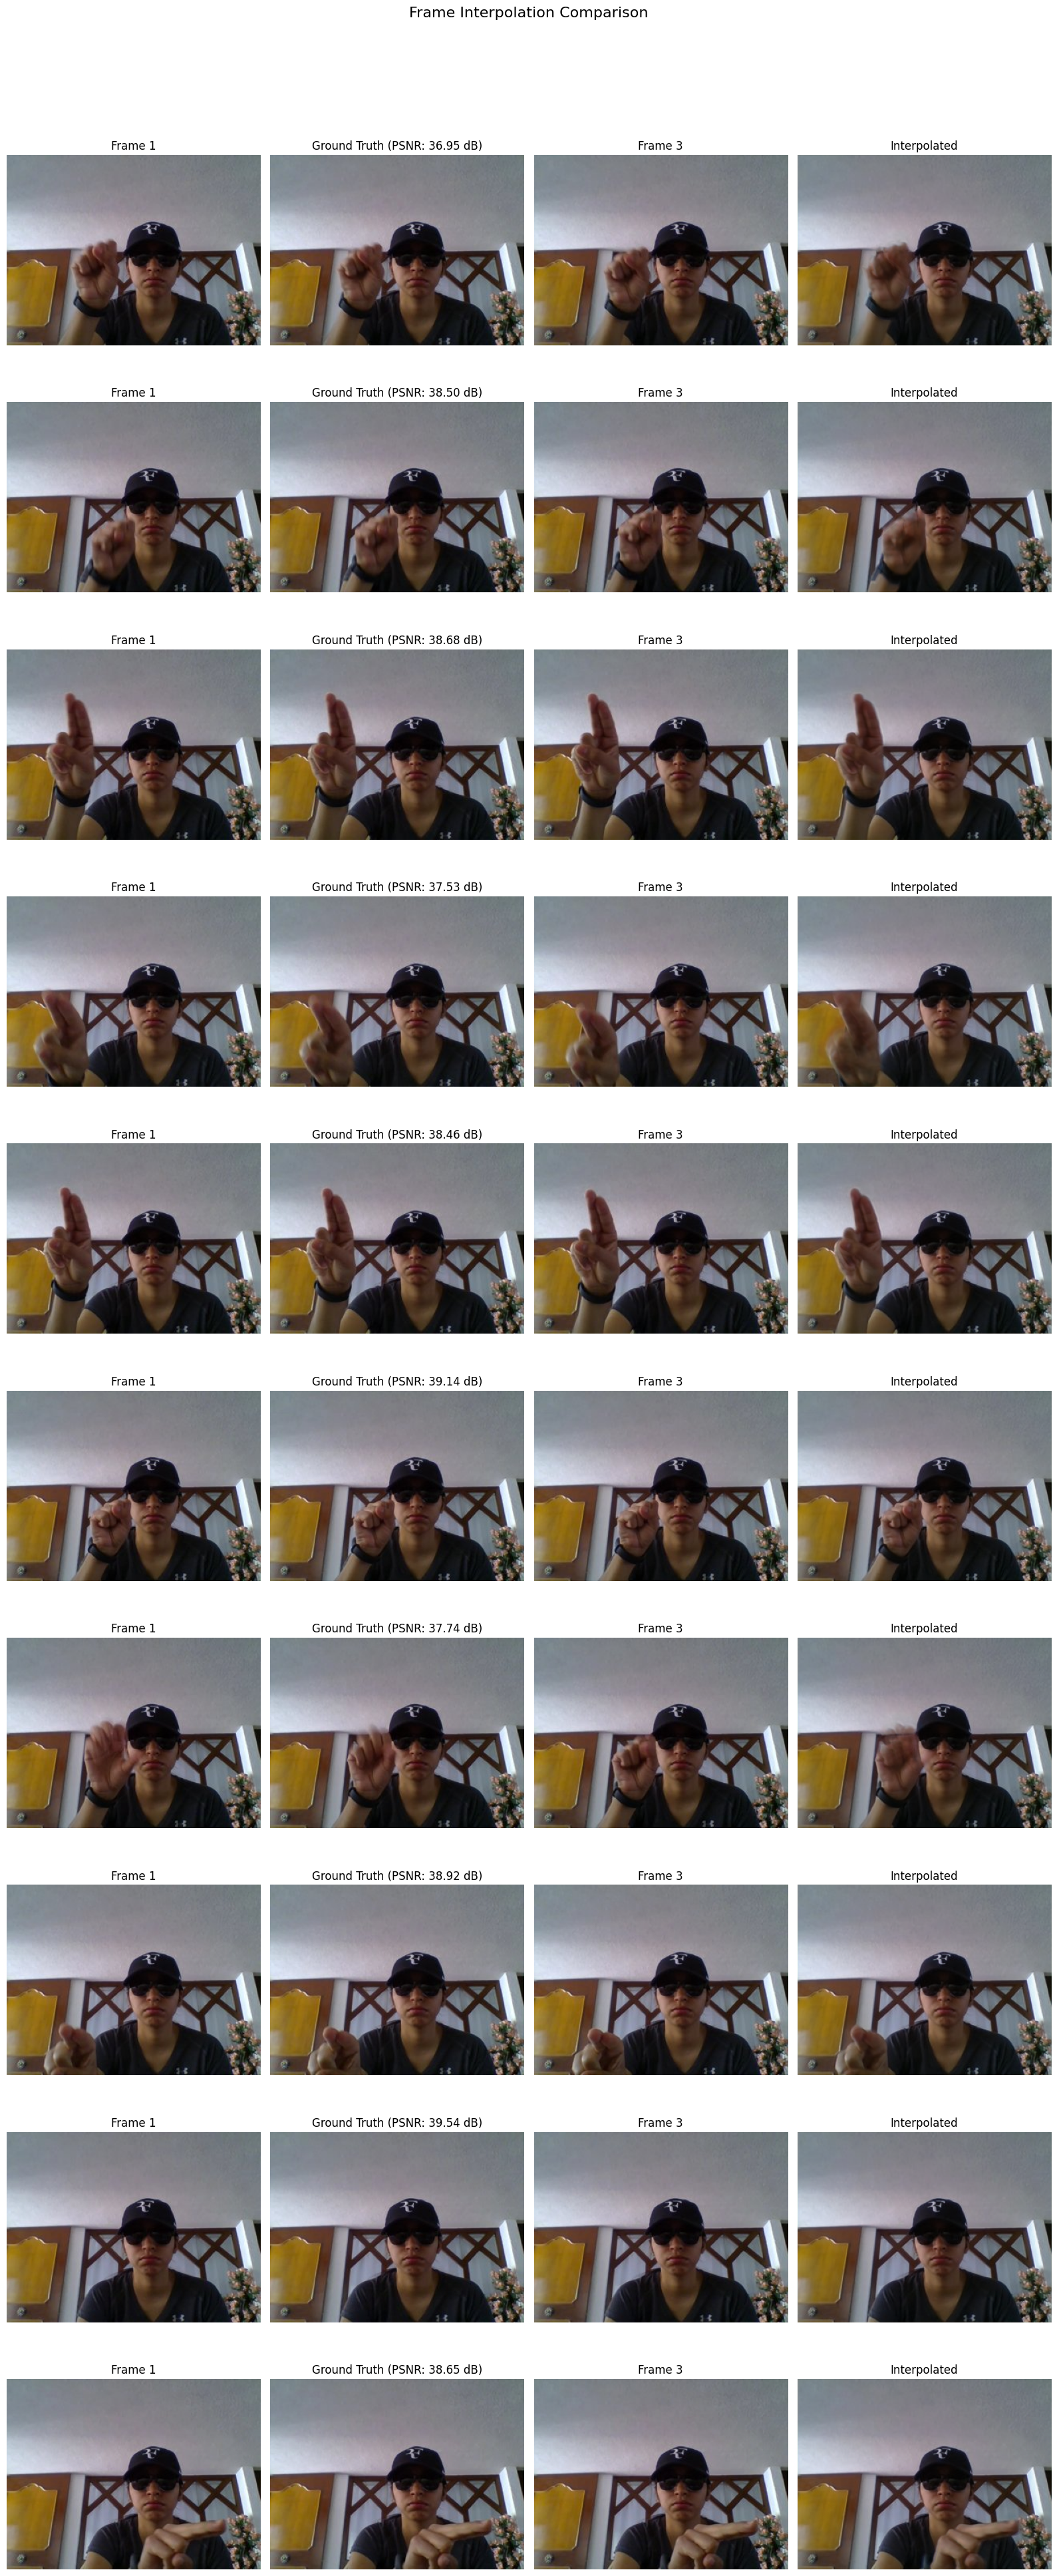

In [31]:
import os
from typing import Generator, Tuple

import cv2  # Add OpenCV for optical flow
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torchvision.models as models
from pytorch_msssim import MS_SSIM


class FrameDataset(Dataset):
    def __init__(self, dir_names: list[str], root_path: str = "data"):
        self._root_path = root_path
        self._transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        ])
        self._data = self._get_frames(dir_names)

    def _get_frame_triples(self, file_names: list[str]) -> Generator[Tuple[str, str, str], None, None]:
        for i in range(len(file_names) - 2):
            yield (file_names[i], file_names[i + 1], file_names[i + 2])

    def _get_frames(self, dir_names: list[str]) -> list[Tuple[str, str, str]]:
        frames = []
        for dir_name in dir_names:
            dir_path = os.path.join(self._root_path, dir_name)
            if not os.path.isdir(dir_path):
                print(f"Warning: {dir_path} is not a directory, skipping.")
                continue
            file_names = sorted(
                [f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            )[:200]
            file_names = [os.path.join(dir_path, file_name) for file_name in file_names]
            frames.extend(self._get_frame_triples(file_names))
        return frames

    def __len__(self) -> int:
        return len(self._data)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        if idx < 0 or idx >= len(self._data):
            raise IndexError("Index out of range")
        try:
            # Load images
            img1 = Image.open(self._data[idx][0]).convert('RGB')
            img2 = Image.open(self._data[idx][1]).convert('RGB')
            img3 = Image.open(self._data[idx][2]).convert('RGB')

            # Convert to OpenCV format for optical flow
            img1_np = np.array(img1)
            img3_np = np.array(img3)
            img1_gray = cv2.cvtColor(img1_np, cv2.COLOR_RGB2GRAY)
            img3_gray = cv2.cvtColor(img3_np, cv2.COLOR_RGB2GRAY)

            # Compute optical flow (Farneback, memory-efficient)
            flow = cv2.calcOpticalFlowFarneback(
                img1_gray, img3_gray, None, 
                pyr_scale=0.5, levels=3, winsize=15, 
                iterations=3, poly_n=5, poly_sigma=1.2, flags=0
            )

            # Convert flow to tensor (H, W, 2) -> (2, H, W)
            flow = flow.astype(np.float32) / 255.0  # Scale to reduce memory
            flow_tensor = torch.from_numpy(flow).permute(2, 0, 1)

            # Apply image transformations
            img1 = self._transform(img1)
            img2 = self._transform(img2)
            img3 = self._transform(img3)

            return img1, img2, img3, flow_tensor
        except Exception as e:
            raise RuntimeError(f"Error loading images at index {idx}: {e}")


def denormalize(tensor: torch.Tensor) -> np.ndarray:
    denorm = transforms.Normalize(mean=(-1, -1, -1), std=(2, 2, 2))
    img = denorm(tensor).permute(1, 2, 0).numpy()
    img = (img * 255).astype(np.uint8)
    return img


def normalize(img: np.ndarray) -> torch.Tensor:
    img = img.astype(np.float32) / 255.0
    img = torch.from_numpy(img).permute(2, 0, 1)
    transform = transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    return transform(img)


def calculate_psnr(img1: torch.Tensor, img2: torch.Tensor) -> float:
    denorm = transforms.Normalize(mean=(-1, -1, -1), std=(2, 2, 2))
    img1 = img1.cpu()
    img2 = img2.cpu()
    img1 = denorm(img1).clamp(0, 1)
    img2 = denorm(img2).clamp(0, 1)
    img1_np = (img1.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    img2_np = (img2.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    mse = np.mean((img1_np - img2_np) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel) - 10 * np.log10(mse)
    return psnr


class FrameInterpolationModel(nn.Module):
    def __init__(self):
        super(FrameInterpolationModel, self).__init__()
        # Input: 6 (2 frames x 3 channels) + 2 (optical flow x, y)
        self.encoder = nn.Sequential(
            nn.Conv2d(8, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, frame1: torch.Tensor, frame3: torch.Tensor, flow: torch.Tensor) -> torch.Tensor:
        x = torch.cat([frame1, frame3, flow], dim=1)  # Concatenate frames and flow
        x = self.encoder(x)
        x = self.decoder(x)
        return x


# Define Perceptual Loss using VGG16
class PerceptualLoss(nn.Module):
    def __init__(self, layer_indices=[3, 8, 15, 22]):  # Layers: conv1_2, conv2_2, conv3_3, conv4_3
        super(PerceptualLoss, self).__init__()
        vgg = models.vgg16(pretrained=True).features.eval()
        self.layers = nn.Sequential(*list(vgg)[:max(layer_indices) + 1])
        self.layer_indices = layer_indices
        for param in self.layers.parameters():
            param.requires_grad = False
        
        # VGG normalization (mean and std for RGB channels)
        self.register_buffer('mean', torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer('std', torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))

    def normalize(self, x):
        return (x - self.mean) / self.std

    def forward(self, pred, target):
        pred = self.normalize(pred)
        target = self.normalize(target)
        pred_features = []
        target_features = []
        
        for i, layer in enumerate(self.layers):
            pred = layer(pred)
            target = layer(target)
            if i in self.layer_indices:
                pred_features.append(pred)
                target_features.append(target)
        
        # Compute MSE loss for each feature map and average
        loss = 0.0
        for pred_f, target_f in zip(pred_features, target_features):
            loss += nn.MSELoss()(pred_f, target_f)
        return loss / len(pred_features)

def train_model(
    model: nn.Module,
    train_dataset: FrameDataset,
    val_dataset: FrameDataset,
    num_epochs: int = 100,
    batch_size: int = 8,
    learning_rate: float = 0.001
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # Define loss functions
    criterion_pixel = nn.L1Loss()
    criterion_perceptual = PerceptualLoss().to(device)
    criterion_ms_ssim = MS_SSIM(data_range=1.0, size_average=True, channel=3).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for frame1, frame2, frame3, flow in train_loader:
            frame1, frame2, frame3, flow = frame1.to(device), frame2.to(device), frame3.to(device), flow.to(device)
            optimizer.zero_grad()
            outputs = model(frame1, frame3, flow)
            
            loss_pixel = criterion_pixel(outputs, frame2)
            loss_perceptual = criterion_perceptual(outputs, frame2)
            loss_ms_ssim = 1 - criterion_ms_ssim(outputs, frame2)
            loss = 1.0 * loss_pixel + 0.1 * loss_perceptual + 0.5 * loss_ms_ssim
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * frame1.size(0)

        train_loss = train_loss / len(train_dataset)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for frame1, frame2, frame3, flow in val_loader:
                frame1, frame2, frame3, flow = frame1.to(device), frame2.to(device), frame3.to(device), flow.to(device)
                outputs = model(frame1, frame3, flow)
                loss_pixel = criterion_pixel(outputs, frame2)
                loss_perceptual = criterion_perceptual(outputs, frame2)
                # loss_ms_ssim = 1 - criterion_ms_ssim(outputs, frame2)  # Uncomment to include MS-SSIM
                loss = 1.0 * loss_pixel + 0.1 * loss_perceptual  # + 0.5 * loss_ms_ssim
                val_loss += loss.item() * frame1.size(0)
        
        val_loss = val_loss / len(val_dataset)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "frame_interpolation_model.pth")
            print(f"Best model saved with Val Loss: {best_val_loss:.6f}")


def load_model(model: nn.Module, path: str = "frame_interpolation_model.pth") -> nn.Module:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.load_state_dict(torch.load(path))
    model = model.to(device)
    model.eval()
    return model


def visualize_triplets(
    triplets: list[Tuple[torch.Tensor, torch.Tensor, torch.Tensor]],
    interpolated_frames: list[torch.Tensor],
    psnr_values: list[float],
    num_triplets: int,
    title: str = "Frame Interpolation Comparison"
) -> None:
    """Visualize multiple triplets and their interpolated frames in a single grid plot."""
    denorm = transforms.Normalize(mean=(-1, -1, -1), std=(2, 2, 2))
    
    # Determine number of rows needed (4 images per triplet: frame1, frame2, frame3, interpolated)
    num_display = min(num_triplets, len(triplets))
    fig, axes = plt.subplots(num_display, 4, figsize=(16, 4 * num_display))
    fig.suptitle(title, fontsize=16)

    for i in range(num_display):
        # Denormalize images
        frame1, frame2, frame3 = [denorm(img).permute(1, 2, 0).cpu().numpy() for img in triplets[i]]
        interpolated = interpolated_frames[i].cpu()
        img_interpolated = denorm(interpolated).permute(1, 2, 0).cpu().numpy()

        # Handle single row case (2D axes array vs 1D)
        ax_row = axes[i] if num_display > 1 else axes

        # Plot images
        ax_row[0].imshow(frame1)
        ax_row[0].set_title("Frame 1")
        ax_row[0].axis('off')

        ax_row[1].imshow(frame2)
        ax_row[1].set_title(f"Ground Truth (PSNR: {psnr_values[i]:.2f} dB)")
        ax_row[1].axis('off')

        ax_row[2].imshow(frame3)
        ax_row[2].set_title("Frame 3")
        ax_row[2].axis('off')

        ax_row[3].imshow(img_interpolated)
        ax_row[3].set_title("Interpolated")
        ax_row[3].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


def test_model(model: nn.Module, test_dataset: FrameDataset, num_triplets: int = 10, visualize: bool = False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)  # Shuffle to avoid repetition
    
    psnr_values = []
    triplets_to_visualize = []
    interpolated_frames = []
    
    # Process triplets
    for i, (frame1, frame2, frame3, flow) in enumerate(test_loader):
        if i >= num_triplets:
            break
            
        frame1, frame2, frame3, flow = frame1.to(device), frame2.to(device), frame3.to(device), flow.to(device)
        
        with torch.no_grad():
            interpolated_frame = model(frame1, frame3, flow).squeeze(0)
        
        # Calculate PSNR
        psnr_value = calculate_psnr(interpolated_frame, frame2.squeeze(0))
        psnr_values.append(psnr_value)
        
        print(f"Triplet {i+1}/{min(num_triplets, len(test_dataset))}: PSNR = {psnr_value:.2f} dB")
        
        # Store for visualization
        if visualize:
            triplets_to_visualize.append((frame1.squeeze(0), frame2.squeeze(0), frame3.squeeze(0)))
            interpolated_frames.append(interpolated_frame)
    
    # Calculate and display mean and standard deviation of PSNR
    mean_psnr = np.mean(psnr_values) if psnr_values else 0
    std_psnr = np.std(psnr_values) if psnr_values else 0
    print(f"\nNumber of triplets evaluated: {len(psnr_values)}")
    print(f"Average PSNR: {mean_psnr:.2f} dB")
    print(f"Standard Deviation of PSNR: {std_psnr:.2f} dB")
    
    # Visualize all triplets in one plot
    if visualize and triplets_to_visualize:
        visualize_triplets(triplets_to_visualize, interpolated_frames, psnr_values, num_triplets)


# Example usage
if __name__ == "__main__":
    data_dirs = os.listdir("data")
    if len(data_dirs) < 2:
        raise ValueError("At least two directories are required for validation and test sets.")

    val_dir = [data_dirs[0]]
    test_dir = [data_dirs[1]]
    train_dir = data_dirs[2:5]

    train_dataset = FrameDataset(train_dir)
    val_dataset = FrameDataset(val_dir)
    test_dataset = FrameDataset(test_dir)

    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")
    print(f"Test dataset size: {len(test_dataset)}")

    if len(train_dataset) == 0 or len(val_dataset) == 0 or len(test_dataset) == 0:
        raise ValueError("One or more datasets are empty.")

    model = FrameInterpolationModel()
    train_model(model, train_dataset, val_dataset, num_epochs=20, batch_size=8, learning_rate=0.001)

    model = load_model(model)
    test_model(model, test_dataset, visualize=True)